In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!python -m spacy download es_core_news_sm #Restart runtime after downloading the model

     |████████████████████████████████| 16.2MB 5.7MB/s 
  Created wheel for es-core-news-sm: filename=es_core_news_sm-2.2.5-cp37-none-any.whl size=16172936 sha256=069a3250c0ce343ab49d8526239b15796b97913bb77fe41dc5530fbdd513f5f0
  Stored in directory: /tmp/pip-ephem-wheel-cache-pybd0z6t/wheels/05/4f/66/9d0c806f86de08e8645d67996798c49e1512f9c3a250d74242
Successfully built es-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_sm')


In [1]:
import nltk
import spacy
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pandas as pd
import pathlib, json
import matplotlib.pyplot as plt

In [49]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import accuracy_score, recall_score, precision_score
import sklearn.metrics as metrics

In [3]:
%cd /content/drive/MyDrive/Projects/mamasita/data
current_path = pathlib.Path().absolute()
clean_lyrics_path = str(current_path) + '/clean_lyrics_extended.csv'
artists_path = str(current_path) + '/artists.json'

/content/drive/MyDrive/Projects/mamasita/data


In [4]:
nltk.download('stopwords')
nltk.download('punkt')
sp = spacy.load('es_core_news_sm')
sp_stopwords = sp.Defaults.stop_words
nltk_stopwords = stopwords.words('spanish')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Just by curiosity, compare the extent of both stopwords set. After inspecting them, the nltk set was chosen since it is less aggresive.

In [5]:
print(len(sp_stopwords))
print(len(nltk_stopwords))

551
313


In [6]:
#Import the clean dataset
songs_df = pd.read_csv(filepath_or_buffer = clean_lyrics_path, header=0, index_col=0)

## Tokenization and stopwords

Even while stopwords and tokenization will be handled later within the modelling pipeline, a quick check of the result is presented hereunder, to have an idea of the result of the process.

In [7]:
def tokenize_column(lyrics:pd.Series):
  return [word_tokenize(l, language='spanish') for l in lyrics]
def remove_stopwords(token_lyrics:pd.Series, stopwords:list):
  return list(map(lambda line: [word for word in line if word not in stopwords], token_lyrics))

songs_df['tokenized'] = tokenize_column(songs_df['lyrics'])
songs_df['tokenized_no_stopwords'] = remove_stopwords(songs_df['tokenized'], nltk_stopwords)
songs_df.head(10)

,title,lyrics,artist,tokenized,tokenized_no_stopwords
0,Yo Se Bien Quien Tu Eres,me pregunto que qué edad yole pongo le dije 1...,Maluma,"[me, pregunto, que, qué, edad, yole, pongo, le...","[pregunto, edad, yole, pongo, dije, 18, ley, s..."
1,Ya No Es Niña,pretty boy dirty boy yo la conocí cuando era...,Maluma,"[pretty, boy, dirty, boy, yo, la, conocí, cuan...","[pretty, boy, dirty, boy, conocí, niña, ahora,..."
2,Vuelo Hacia El Olvido,eh ye ye ye aohoh me llevo tus abrigos para ...,Maluma,"[eh, ye, ye, ye, aohoh, me, llevo, tus, abrigo...","[eh, ye, ye, ye, aohoh, llevo, abrigos, frio, ..."
3,Zombie (feat. Yaviah),metiendo miedo como zombie azicalao con las t...,Alexis y Fido,"[metiendo, miedo, como, zombie, azicalao, con,...","[metiendo, miedo, zombie, azicalao, tennis, co..."
4,Vuelve (feat. Paulina Rubio & DCS),tengo la sensación de que no vuelves nunca te...,Juan Magan,"[tengo, la, sensación, de, que, no, vuelves, n...","[sensación, vuelves, nunca, mente, grabado, mo..."
5,Tu Y Yo,sabes quien llego gente de zona una ves mas ...,Gente de Zona,"[sabes, quien, llego, gente, de, zona, una, ve...","[sabes, llego, gente, zona, ves, mas, nunca, a..."
6,YO VISTO ASÍ,yehyeh yeh yehyeh yehyeh yehyeh yehyeh yehy...,Bad Bunny,"[yehyeh, yeh, yehyeh, yehyeh, yehyeh, yehyeh, ...","[yehyeh, yeh, yehyeh, yehyeh, yehyeh, yehyeh, ..."
7,Yo soy tu hombre,las knarias con nicky jam… ya tu sabes como v...,Nicky Jam,"[las, knarias, con, nicky, jam…, ya, tu, sabes...","[knarias, nicky, jam…, sabes, va, dice…, 40, 2..."
8,Yo Te Lo Dije,pero yo te dejé todo claro en que habíamos q...,J Balvin,"[pero, yo, te, dejé, todo, claro, en, que, hab...","[dejé, claro, quedado, ?, dije, ah, dije, iba,..."
9,Yo Quiero Ser,llevo tanto tiempo esperando que regreses lle...,J Balvin,"[llevo, tanto, tiempo, esperando, que, regrese...","[llevo, tiempo, esperando, regreses, llevo, ti..."


## Label the dataset

THe dataset has been labelled as a binary variable (is reggaeton: YES -> 1, NO -> 0). The dictionary of artists scraped is used as a reference to identify which songs are sung by reggaeton artists.

In [8]:
with open(artists_path) as f:
        artists_dict = json.load(f)

In [10]:
def normalize_artists(artist_series:pd.Series):
  replacements = [(' & ', ' y '), ('á', 'a'), ('é', 'e') , ('í', 'i'), ('ó', 'o'), ('ú', 'u')]
  for replacement in replacements:
    artist_series = [l.replace(replacement[0], replacement[1]) for l in artist_series]
  return artist_series
songs_df['artist'] = normalize_artists(songs_df['artist'])

In [12]:
def label_rows(df:pd.DataFrame):
  artists_reggaeton = ['maluma', 'don omar', 'wisin y yandel', 'alexis y fido',
                     'dady yankee', 'juan magan', 'gente de zona', 'bad bunny',
                     'nicky jam', 'j balvin', 'kevin roldan', 'anuel aa', 
                     'los legendarios', 'dalex', 'feid', 'arcangel', 'zion y lennox']
  df['artist'] = df['artist'].str.lower()
  df['is_reggaeton'] = ''
  for index in range(len(df)):
    if df['artist'].iloc[index] in artists_reggaeton:
      df['is_reggaeton'].iloc[index] = 1
    else:
      df['is_reggaeton'].iloc[index] = 0
  for artist in df['artist'].unique():
    if len(df[df['artist']==artist])<5:
      df = df.drop(df.index[df['artist']==artist])
  return df

songs_df = label_rows(songs_df)

The disclosure of the 1290 reggaeton songs by artist is shown hereunder

In [21]:
songs_df[songs_df['is_reggaeton']==1].groupby(['artist']).count()['title']

artist
alexis y fido    127
anuel aa          93
arcangel         248
bad bunny        113
dalex             56
feid              45
gente de zona     30
j balvin         154
juan magan        70
maluma           164
nicky jam        190
Name: title, dtype: int64

The disclosure of the 1645 non-reggaeton songs by artists is shown hereunder.

In [19]:
songs_df[songs_df['is_reggaeton']==0].groupby(['artist']).count()['title']

artist
amaral                  101
ana tijoux               66
canserbero               62
el canto del loco       114
el chojin                66
estopa                  154
fito y fitipaldis        64
joan manuel serrat      380
melendi                 162
pablo milanes           181
pereza                  100
residente                28
vico c                  117
violadores del verso     50
Name: title, dtype: int64

## Create the train and test sets

A 30% of the total dataset is left as a validation set, while keeping the rest as training. A more complex validation strategy is to be implemented in future updates.

In [26]:
X_train, X_valid, y_train, y_valid = train_test_split(songs_df.lyrics.values, songs_df.is_reggaeton.values, 
                                                      stratify=songs_df.is_reggaeton.values, random_state=11,
                                                      test_size=0.30, shuffle=True)

We can verify that the stratification of observations labelled as reggaeton is uniform for both sets:

In [27]:
print('The proportion of reggaeton songs in the train and validation datasets is: Train -> \
{0:0.2f}, Validation -> {1:0.2f}'.format(y_train.sum()/y_train.size, y_valid.sum()/y_valid.size)) 

The proportion of reggaeton songs in the train and validation datasets is: Train -> 0.44, Validation -> 0.44


The lyrics are vectorized with the scikit learn CountVectorizer class. Stopwords and tokenization are also addressed in this step.

In [28]:
countVec = CountVectorizer(encoding='utf-8', stop_words=nltk_stopwords,
                           tokenizer=lambda x: word_tokenize(x, language='spanish'))
X_train_vec = countVec.fit_transform(X_train)
X_valid_vec = countVec.transform(X_valid)
y_valid = y_valid.astype('int')
y_train = y_train.astype('int')

A simple logistic regression model and a multinomial bayesian models are initially run.

In [63]:
logReg = LogisticRegression(C=1.0, max_iter=1000)
logReg.fit(X_train_vec, y_train)
predictions_logReg = logReg.predict(X_valid_vec)
print(f'Logistic regression accuracy {accuracy_score(predictions_logReg, y_valid):0.3f}')
print(f'Logistic regression recall {recall_score(predictions_logReg, y_valid):0.3f}')
print(f'Logistic regression precision {precision_score(predictions_logReg, y_valid):0.3f}')

Logistic regression accuracy 0.914
Logistic regression recall 0.936
Logistic regression precision 0.863


In [30]:
mnb = MultinomialNB()
mnb.fit(X_train_vec, y_train)
predictions_mnb = mnb.predict(X_valid_vec)
print(f'Multinomial naives Bayes accuracy {accuracy_score(predictions_mnb, y_valid):0.3f}')
print(f'Multinomial naives Bayes recall {recall_score(predictions_mnb, y_valid):0.3f}')
print(f'Multinomial naives Bayes precision {precision_score(predictions_mnb, y_valid):0.3f}')

Multinomial naives Bayes accuracy 0.939
Multinomial naives Bayes recall 0.919
Multinomial naives Bayes precision 0.943


As it can be seen, both models achieve a relatively high performance for this first approach, specially the MNB model.

ROC curve

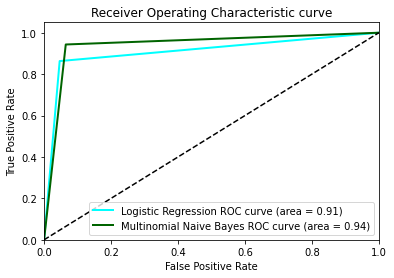

In [31]:
y_pred=[predictions_logReg, predictions_mnb]
fpr = [0, 0]
tpr = [0, 0]
auc = [0, 0]
for idx in range(len(y_pred)):
  fpr[idx], tpr[idx], _ = metrics.roc_curve(y_valid, y_pred[idx])
  auc[idx] = metrics.auc(fpr[idx], tpr[idx])
plt.figure()
colors = ['aqua', 'darkgreen']
model_labels = ['Logistic Regression', 'Multinomial Naive Bayes']
for idx in range(len(auc)):
  plt.plot(fpr[idx], tpr[idx], color=colors[idx], lw=2,
          label='{0:s} ROC curve (area = {1:0.2f})'.format(model_labels[idx], auc[idx]))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title('Receiver Operating Characteristic curve')
plt.legend(loc="lower right")
plt.show()

In the confusion matrices plotted below it can be seen as the main difference between the model performance is that the logistic regression struggles to classify a significant higher amount of reggaeton songs

Text(0.5, 1.0, 'Multinomial Naive Bayes - confusion matrix')

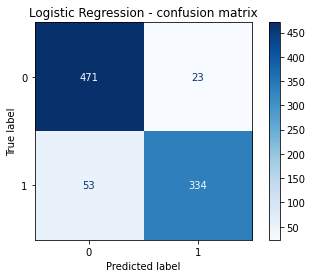

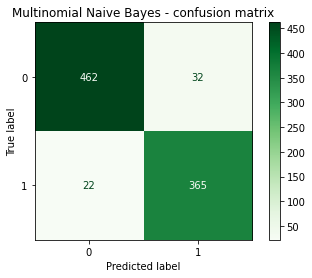

In [64]:
logReg_confMat = metrics.plot_confusion_matrix(logReg, X_valid_vec, y_valid, values_format='d', cmap=plt.cm.Blues)
logReg_confMat.ax_.set_title('Logistic Regression - confusion matrix')
mnb_confMat = metrics.plot_confusion_matrix(mnb, X_valid_vec, y_valid, values_format='d', cmap=plt.cm.Greens)
mnb_confMat.ax_.set_title('Multinomial Naive Bayes - confusion matrix')

## Model insights

The main advantage of these two models is that we can easily inspect which are the most influent tokens, either by the regression coefficient associated to them or by the log probability of the token if reggaeton.

#### Logistic regression most distinctive tokens

As it can be seen, the most distictive tokens for the logistic model are sensual / dancing / flirting words like baby, mami, gusta, sentir, quieres, lento, amo among others (meaning: baby, mamma, you like, to feel, you want, slowly, I love). This are pulled by sorting the words by decreasing order of the regression coefficient associated. Also some singer names are included (Maluma). It is interesting that words with tiny count values score high in the coefficient associated.

In [68]:
important_tokens_logReg = pd.DataFrame(
    data= logReg.coef_[0],
    index= countVec.get_feature_names(),
    columns=['coefficient']
)
counts = X_train_vec.toarray().sum(axis=0)
important_tokens_logReg['counts'] = counts.transpose()
important_tokens_logReg.sort_values(by='coefficient', ascending=False).head(20)

,coefficient,counts
baby,0.853824,1426
mami,0.783024,782
gusta,0.703237,724
amo,0.608753,119
tócate,0.589877,3
acorrrrdeon,0.554649,3
sentir,0.541207,235
flow,0.521067,391
quieres,0.510703,996
ey,0.506836,614


#### Multinomial Naive Bayes most distinctive tokens

As done for the logistic regresion, the tokens are sorted in decreasing order, this time using the ratio between probability of the token if reggaetion by probability of the token if not reggaeton. Interestingly, there are few coincidences with the logistic regression model, while many appearances of the singer names (arcangel, Maluma, Nicky -Jam-, balvin, alexis, anuel and Fido).

In [76]:
important_tokens_mnb = pd.DataFrame(
    data= np.exp(mnb.feature_log_prob_[1]),
    index= countVec.get_feature_names(),
    columns=['prob_1']
)
important_tokens_mnb['prob_0'] =np.exp(mnb.feature_log_prob_[0])
important_tokens_mnb['prob_1 / prob_0'] =important_tokens_mnb['prob_1'] /important_tokens_mnb['prob_0']
important_tokens_mnb['total occurence'] =X_train_vec.toarray().sum(axis=0)
important_tokens_mnb.sort_values(by='prob_1 / prob_0', ascending=False).head(10)

,prob_1,prob_0,prob_1 / prob_0,total occurence
uah,0.001095,0.000005,227.053238,259
arcangel,0.000822,0.000005,170.289928,194
balvin,0.000800,0.000005,165.923520,189
maluma,0.000750,0.000005,155.444140,177
nicky,0.001643,0.000014,113.526619,391
party,0.001041,0.000010,107.850288,247
alexis,0.000518,0.000005,107.413647,122
yal,0.000501,0.000005,103.920520,118
brr,0.000480,0.000005,99.554112,113
vamo,0.000472,0.000005,97.807549,111


When sorting by just the probability of the token if reggaeton, the top of the ranking seems more silirar to that one of the logistic regresion, with words like amor, quiero, quieres and baby.

In [77]:
important_tokens_mnb = pd.DataFrame(
    data= np.exp(mnb.feature_log_prob_[1]),
    index= countVec.get_feature_names(),
    columns=['prob_1']
)
important_tokens_mnb['prob_0'] =np.exp(mnb.feature_log_prob_[0])
important_tokens_mnb['prob_1 / prob_0'] =important_tokens_mnb['prob_1'] /important_tokens_mnb['prob_0']
important_tokens_mnb['total occurence'] =X_train_vec.toarray().sum(axis=0)
important_tokens_mnb.sort_values(by='prob_1', ascending=False).head(10)

,prob_1,prob_0,prob_1 / prob_0,total occurence
si,0.014505,0.009962,1.456033,5506
quiero,0.007992,0.005225,1.529654,2978
baby,0.005835,0.000207,28.127794,1426
voy,0.005489,0.002904,1.890176,1903
oh,0.005140,0.000598,8.591965,1342
?,0.004828,0.004839,0.997787,2147
bien,0.004158,0.002977,1.396968,1602
amor,0.003813,0.003493,1.091602,1627
siempre,0.003581,0.003734,0.959030,1622
quieres,0.003556,0.000743,4.786037,996


## Lyrics playground

Just as an initial playground, on "Are your lyrics reggaetonian?". We can introduce a string and check how they get classified.

In [72]:
my_x = np.ndarray((1), dtype='O' )
my_x[:] = 'vamos a bailar mami'
my_X_vec = countVec.transform(my_x)
print('The veredict of MN Bayes is: {0} \n The veredict of Logistic regression is {1}'.format(mnb.predict(my_X_vec), clf.predict(my_X_vec)))

The veredict of MN Bayes is: [1] 
 The veredict of Logistic regression is [0]
